In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')
from nltk.corpus import inaugural
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from rake_nltk import Rake

from nltk.util import ngrams, bigrams, trigrams

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import LdaModel

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import collections
from collections import Counter
from itertools import chain

import simplemma
from functools import reduce
import joblib
from random import Random

import dataframe_image as dfi

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv("bigdata-W-UD.csv")

In [4]:
df = df.drop(['Unnamed: 0', 'Machine_Translation', 'toxicity', 'severe_toxicity'], 1)

C:\Users\anton\AppData\Local\Temp/ipykernel_39856/2484073893.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Unnamed: 0', 'Machine_Translation', 'toxicity', 'severe_toxicity'], 1)


In [5]:
df

,id,post.nr,date,n,phaseType,Labels,comment_text
0,2320,1,4/7/2017,51,A,0,fick just samtal att en lastbil kört över mass...
1,2369,2,4/7/2017,116,A,0,andra trådar kopplade till terrorattentatet på...
2,1444,3,4/7/2017,15,A,0,har även jag hört från en på plats nya spänna...
3,2428,4,4/7/2017,17,A,0,enligt nyhetsflash från aftonbladet har en las...
4,2470,5,4/7/2017,1,A,0,terrorattack
...,...,...,...,...,...,...,...
14587,137,14709,12/23/2021,11,C,0,muhammad mördade både kvinnor barn och äldre ...
14588,1123,14710,12/24/2021,261,C,0,tack för ditt intressanta inlägg det är rel...
14589,39,14711,12/24/2021,23,C,0,problemet är att sverige har ingen skarprättar...
14590,1884,14712,12/25/2021,60,C,1,även en blind höna hittar ett korn dvs det är...


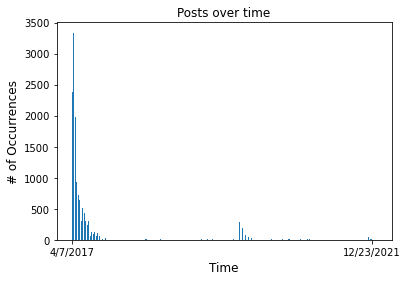

In [6]:
x = df['date']
plt.hist(x, bins=500)
plt.title("Posts over time")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.xticks(['4/7/2017', '12/23/2021'])
plt.show()

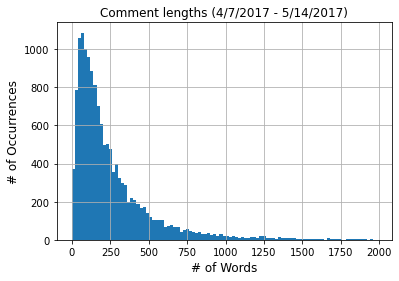

In [7]:
lens = df.comment_text.str.len()
plt.title("Comment lengths (4/7/2017 - 5/14/2017)")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Words', fontsize=12)
lens.hist(bins = np.arange(0,2000,20))
plt.savefig('ave_com_lenght.jpg', bbox_inches='tight')

In [8]:
df = df[df.Labels != 2]

In [9]:
df = df[df['post.nr'] < 13124]

In [10]:
df

,id,post.nr,date,n,phaseType,Labels,comment_text
0,2320,1,4/7/2017,51,A,0,fick just samtal att en lastbil kört över mass...
1,2369,2,4/7/2017,116,A,0,andra trådar kopplade till terrorattentatet på...
2,1444,3,4/7/2017,15,A,0,har även jag hört från en på plats nya spänna...
3,2428,4,4/7/2017,17,A,0,enligt nyhetsflash från aftonbladet har en las...
4,2470,5,4/7/2017,1,A,0,terrorattack
...,...,...,...,...,...,...,...
13018,1064,13119,5/13/2017,389,B,0,ja rättsstat minns jag inte om den finns defi...
13019,2481,13120,5/14/2017,367,B,0,rättsstat jag har väl inte så mycket mer att...
13020,1064,13121,5/14/2017,194,B,0,undrar vad polis emma sa till akilov då hon br...
13021,2481,13122,5/14/2017,146,B,0,en händelsekedja över den påstådde mgm vore br...


In [11]:
stop_words = stopwords.words('swedish')
stemmer = SnowballStemmer("swedish")


new_stopwords = ["ska", "bara", "får", "in", "dom", "vill", "väl", "mer", "vet", "ta", "göra", "gör", "tror", "andra", "kommer", "finns", "få", "kanske", "helt", "många", "också", "lite", "ser", "måste", "även", "hela", "tycker", "ens", "ja", "inget", "se", "går", "the", "just", "rätt", "säger", "nog"
                ,"sen", "är", "bra", "innan", "tar", "verkar", "annat", "borde", "fått", "fick", "år", "sitt", "gå", "sett", "o", "direkt", "personer", "nej", "aldrig", "precis",
                "fel", "gm", "flera", "sätt", "a", "fler", "gjort", "komma", "hoppas", "alltså", "kunna", "redan", "såg", "landet", "nån", "ner", "and", "tid", "ligger", "eftersom",
                "ändå", "gjorde", "idén", "helst", "istället", "haft", "runt", "själva", "jo", "kl", "km", "nr"]
                
stopwords.extend(new_stopwords)

In [12]:
def tokenize(text):
    for word in text:
        yield(gensim.utils.simple_preprocess(str(word), deacc=False))

In [13]:
df['tokenized'] = list(tokenize(df['comment_text']))

In [14]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(text)) if word not in stop_words] for text in texts]

In [15]:
df['comment_NoStopWord'] = remove_stopwords(df['tokenized'])

In [16]:
langdata = simplemma.load_data('en')

In [17]:
df['comment_lemmatized'] = df['comment_NoStopWord'].apply(lambda x : [simplemma.lemmatize(y,langdata) for y in x])

In [18]:
df['comment_stemmed'] = df['comment_NoStopWord'].apply(lambda x : [stemmer.stem(y) for y in x])

In [19]:
df["comment_lemmatized_joined"] = df['comment_lemmatized'].str.join(' ')

In [20]:
df['comment_NoStop_joined'] = df['comment_NoStopWord'].str.join(' ')

In [21]:
df['comment_stemmed_joined'] = df['comment_stemmed'].str.join(' ')

In [22]:
df

,id,post.nr,date,n,phaseType,Labels,comment_text,tokenized,comment_NoStopWord,comment_lemmatized,comment_stemmed,comment_lemmatized_joined,comment_NoStop_joined,comment_stemmed_joined
0,2320,1,4/7/2017,51,A,0,fick just samtal att en lastbil kört över mass...,"[fick, just, samtal, att, en, lastbil, kört, ö...","[fick, just, samtal, lastbil, kört, massa, fol...","[fick, just, samtal, lastbil, kört, massa, fol...","[fick, just, samtal, lastbil, kört, mass, folk...",fick just samtal lastbil kört massa folk drott...,fick just samtal lastbil kört massa folk drott...,fick just samtal lastbil kört mass folk drottn...
1,2369,2,4/7/2017,116,A,0,andra trådar kopplade till terrorattentatet på...,"[andra, trådar, kopplade, till, på, drottningg...","[andra, trådar, kopplade, drottninggatan, fb, ...","[andra, trådar, kopplade, drottninggatan, fb, ...","[andr, tråd, koppl, drottninggatan, fb, komm, ...",andra trådar kopplade drottninggatan fb kommer...,andra trådar kopplade drottninggatan fb kommer...,andr tråd koppl drottninggatan fb komm terrord...
2,1444,3,4/7/2017,15,A,0,har även jag hört från en på plats nya spänna...,"[har, även, jag, hört, från, en, på, plats, ny...","[även, hört, plats, nya, spännande, sverige, t...","[även, hört, plat, nya, spännande, sverige, ty...","[även, hört, plat, nya, spänn, sver, tyd, mins...",även hört plat nya spännande sverige tydligen ...,även hört plats nya spännande sverige tydligen...,även hört plat nya spänn sver tyd minst påkörd
3,2428,4,4/7/2017,17,A,0,enligt nyhetsflash från aftonbladet har en las...,"[enligt, nyhetsflash, från, aftonbladet, har, ...","[enligt, nyhetsflash, aftonbladet, lastbil, kö...","[enligt, nyhetsflash, aftonbladet, lastbil, kö...","[enl, nyhetsflash, aftonbladet, lastbil, kört,...",enligt nyhetsflash aftonbladet lastbil kört in...,enligt nyhetsflash aftonbladet lastbil kört in...,enl nyhetsflash aftonbladet lastbil kört in fo...
4,2470,5,4/7/2017,1,A,0,terrorattack,[terrorattack],[terrorattack],[terrorattack],[terrorattack],terrorattack,terrorattack,terrorattack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13018,1064,13119,5/13/2017,389,B,0,ja rättsstat minns jag inte om den finns defi...,"[ja, rättsstat, minns, jag, inte, om, den, fin...","[ja, rättsstat, minns, finns, definierat, lag,...","[ja, rättsstat, minns, finns, definierat, lag,...","[ja, rättsst, minn, finn, definier, lag, mer, ...",ja rättsstat minns finns definierat lag mera f...,ja rättsstat minns finns definierat lag mera f...,ja rättsst minn finn definier lag mer filosofi...
13019,2481,13120,5/14/2017,367,B,0,rättsstat jag har väl inte så mycket mer att...,"[rättsstat, jag, har, väl, inte, så, mycket, m...","[rättsstat, väl, mer, säga, delen, kommentar, ...","[rättsstat, väl, mer, säga, delen, kommentar, ...","[rättsst, väl, mer, säg, del, komment, erkän, ...",rättsstat väl mer säga delen kommentar erkänna...,rättsstat väl mer säga delen kommentar erkänna...,rättsst väl mer säg del komment erkän säg vet ...
13020,1064,13121,5/14/2017,194,B,0,undrar vad polis emma sa till akilov då hon br...,"[undrar, vad, polis, emma, sa, till, akilov, d...","[undrar, polis, emma, sa, akilov, brottade, ne...","[undrar, polis, emma, sa, akilov, brottade, ne...","[undr, polis, emm, sa, akilov, brott, ned, mär...",undrar polis emma sa akilov brottade ned märst...,undrar polis emma sa akilov brottade ned märst...,undr polis emm sa akilov brott ned märst fatt ...
13021,2481,13122,5/14/2017,146,B,0,en händelsekedja över den påstådde mgm vore br...,"[en, händelsekedja, över, den, påstådde, mgm, ...","[händelsekedja, påstådde, mgm, vore, bra, etab...","[händelsekedja, påstådde, mgm, vore, bra, etab...","[händelsekedj, påståd, mgm, vor, bra, etabler,...",händelsekedja påstådde mgm vore bra etablera g...,händelsekedja påstådde mgm vore bra etablera g...,händelsekedj påståd mgm vor bra etabler grip b...


In [1998]:
df_nTox = df[df['Labels'] == 0]

In [1999]:
df_tox = df[df['Labels'] == 1]

In [2000]:
cTox = len(df[df['Labels'] == 1])
cNonT = len(df[df['Labels'] == 0])

d_stat = {'Labels': ['Toxic', 'Non-Toxic'], 'Number_of_comments': [cTox, cNonT]}

In [2001]:
d_stat = pd.DataFrame(d_stat)
d_stat

,Labels,Number_of_comments
0,Toxic,1146
1,Non-Toxic,11545


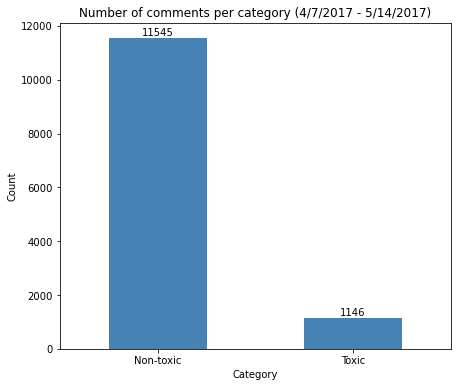

In [2003]:
labs = df['Labels'].value_counts()
plt.figure(figsize=(7, 6))
ax = labs.plot(kind='bar', rot=0, color="steelblue")
ax.set_title("Number of comments per category (4/7/2017 - 5/14/2017)", y = 1)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_xticklabels(('Non-toxic', 'Toxic'))

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

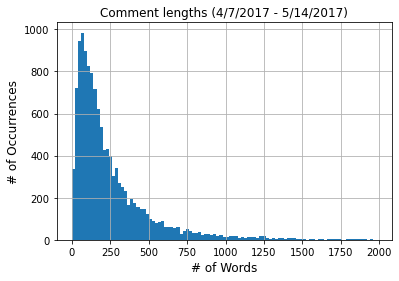

In [1639]:
lens = df.comment_text.str.len()
plt.title("Comment lengths (4/7/2017 - 5/14/2017)")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Words', fontsize=12)
lens.hist(bins = np.arange(0,2000,20))
plt.savefig('ave_com_lenght.jpg', bbox_inches='tight')

In [1828]:
tox_text = df_tox['comment_NoStop_joined']

In [1829]:
tox_text

40       is presenterat andra gången sverige bara beklaga drabbats förhoppningsvis innebär får samordnare...
67       väntat svenskarna slutade betala is terroristernas körkort känner sverige svajar samarbetet sak ...
80       expressens ehh åhh ehrm reporter vägrar säga ordet terrordåd understryker händelse oväntat bara ...
88                                                                                       skrev lilla horunge
90       jävla spöke svt intervjuade nyss lastbilschafför fått hjärnblödning därför tryckt full gas kört ...
                                                        ...                                                 
12939    ber få rätta ebba enda barnet separerade föräldrar stod nära framförallt mamma förbannade terror...
12961                                  herrejävlar pajasland rahkmat akilov knyts adress terrorfinansiär fan
12972    säpo fuckat up besviken ranstorp tv klippen försvarar säpo jämförelse fotbollen kommer ihåg rädd...
12988    edit förra

In [1830]:
nonT_text = df_nTox['comment_NoStop_joined']

In [1831]:
def plot_top_non_stopwords_barchart(text):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:15]:
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

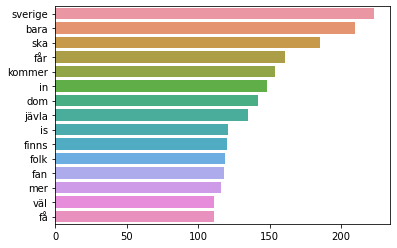

In [1832]:
plot_top_non_stopwords_barchart(tox_text)
plt.savefig('top_tox.jpg', bbox_inches='tight')

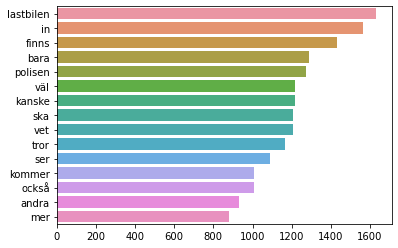

In [1833]:
plot_top_non_stopwords_barchart(nonT_text)
plt.savefig('top_nTox.jpg', bbox_inches='tight')

In [1464]:
#df_tox['comment_NoStopWord'] = df["comment_NoStopWord"].str.lower().str.split()

In [1465]:
#df_tox['comment_NoStopWord'] = df_tox['comment_NoStopWord'].astype('str') 

In [1466]:
#df_tox['bigrams'] = df_tox['comment_NoStopWord'].apply(lambda row: list(nltk.ngrams(row, 2)))

In [1467]:
#df_tox['trigrams'] = df_tox['comment_NoStopWord'].apply(lambda row: list(nltk.ngrams(row, 3)))

In [1468]:
#df_tox['comment_stemmed'] = df_tox['comment_stemmed'].astype('str') 

In [1834]:
def plot_top_ngrams_barchart(text, n):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:15]

    top_n_bigrams=_get_top_ngram(text,n)[:6]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

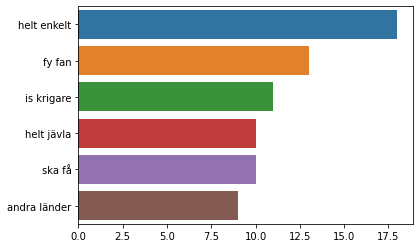

In [1835]:
plot_top_ngrams_barchart(tox_text, 2)
plt.savefig('tox_bi.jpg', bbox_inches='tight')

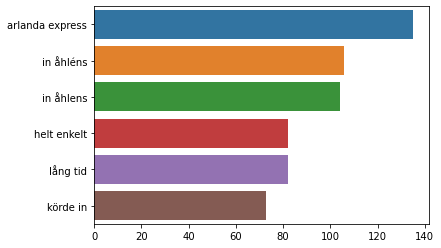

In [1836]:
plot_top_ngrams_barchart(nonT_text, 2)
plt.savefig('nTox_bi.jpg', bbox_inches='tight')

## Topic modelling - checking optimal hyperparams

In [1472]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

In [23]:
cv = CountVectorizer()                       

In [24]:
cv_matrix = cv.fit_transform(df['comment_lemmatized_joined'].values.astype('U')) 

In [25]:
cv_matrix = cv_matrix.toarray()

In [1476]:
def topic_model_coherence_generator(topic_num_start='',
                                    topic_num_end='',
                                    norm_corpus='',
                                    cv_matrix='',
                                    cv=''):
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]
    models = []
    coherence_scores = []

    for i in range(topic_num_start, topic_num_end):
        print(i)
        cur_lda = LatentDirichletAllocation(n_components=i,
                                            max_iter=30,
                                            random_state=0)
        cur_lda.fit_transform(cv_matrix)
        cur_coherence_score = metric_coherence_gensim(
            measure='c_v',
            top_n=5,
            topic_word_distrib=cur_lda.components_,
            dtm=cv.fit_transform(norm_corpus),
            vocab=np.array(cv.get_feature_names_out()),
            texts=norm_corpus_tokens)
        models.append(cur_lda)
        coherence_scores.append(np.mean(cur_coherence_score))
    return models, coherence_scores

In [1477]:
%%time
ts = 1
te = 31
models, coherence_scores = topic_model_coherence_generator(
    ts, te, norm_corpus=df['comment_lemmatized_joined'].values.astype('U'), cv=cv, cv_matrix=cv_matrix)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
Wall time: 1h 54min 26s


In [1480]:
coherence_scores

[0.3408475044568732,
 0.5234651432627235,
 0.5419291512552801,
 0.5194699794745818,
 0.516357727641463,
 0.5473892911434511,
 0.5320294466462621,
 0.5752174726672172,
 0.574603966886365,
 0.580720031480872,
 0.5705267333574828,
 0.5700159939875394,
 0.5740630519681239,
 0.5838184683354778,
 0.5585872649471465,
 0.5716173540924913,
 0.5789380019671959,
 0.5669646557869465,
 0.5977913355343631,
 0.5747377348121521,
 0.5854196595464932,
 0.5805044246160818,
 0.6082883839070842,
 0.6101545723256302,
 0.6274246761254196,
 0.595376590113672,
 0.5811119817357037,
 0.593964833648143,
 0.5778030667654143,
 0.5896932895527008]

In [1481]:
coherence_df = pd.DataFrame({
    'TOPIC_NUMBER': [i for i in range(ts, te)],
    'COHERENCE_SCORE': np.round(coherence_scores, 4)
})

coherence_df.sort_values(by=["COHERENCE_SCORE"], ascending=False)

,TOPIC_NUMBER,COHERENCE_SCORE
24,25,0.6274
23,24,0.6102
22,23,0.6083
18,19,0.5978
25,26,0.5954
27,28,0.5940
29,30,0.5897
20,21,0.5854
13,14,0.5838
26,27,0.5811


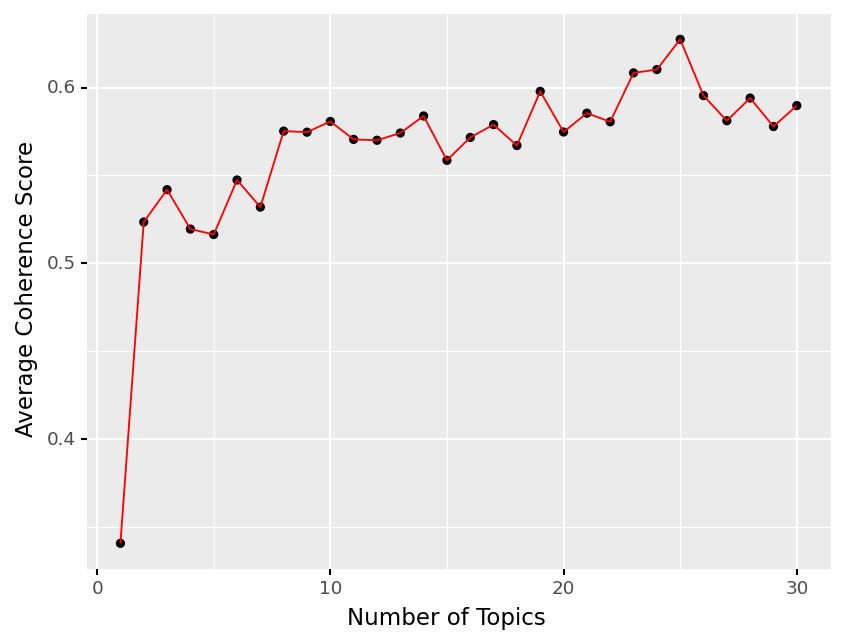

<ggplot: (133485886127)>

In [1482]:
import plotnine
from plotnine import ggplot, aes, geom_point, geom_line, labs
plotnine.options.dpi = 150

g = (ggplot(coherence_df) + aes(x="TOPIC_NUMBER", y="COHERENCE_SCORE") +
     geom_point(stat="identity") + geom_line(group=1, color="red") +
     labs(x="Number of Topics", y="Average Coherence Score"))
g

## Create seeded LDA based on optimal params

In [39]:
lda14 = LatentDirichletAllocation(n_components = 14,
                                 max_iter = 80,
                                 random_state = 123)

In [40]:
df = df[['post.nr', 'id', 'date', 'n', 'phaseType', 'Labels', 'comment_text', 'comment_lemmatized_joined']]
df = pd.DataFrame(df)

In [41]:
df = df.reset_index()

In [42]:
lda_output14 = lda14.fit_transform(cv_matrix)

joblib.dump(lda14, 'ldamodel14.jl')

In [28]:
#lda14 = joblib.load('ldamodel14.jl')

In [43]:
topic_names14 = ["Topic" + str(i) for i in range(1, lda14.n_components + 1)]

In [44]:
df_document_topic14 = pd.DataFrame(np.round(lda_output14,2), columns = topic_names14)

In [45]:
dominant_topic14 = (np.argmax(df_document_topic14.values, axis=1)+1)

In [46]:
df_document_topic14['Dominant_topic'] = dominant_topic14

In [47]:
df14 = pd.merge(df, df_document_topic14, left_index = True, right_index = True, how='outer')

In [48]:
keywords = np.array(cv.get_feature_names())

topic_keywords = []

for topic_weights in lda14.components_:
    top_keyword_locs = (-topic_weights).argsort()[:20]
    topic_keywords.append(keywords.take(top_keyword_locs))

for i in topic_keywords:
    print(i)

['ska' 'stockholm' 'fb' 'också' 'verkar' 'nice' 'berlin' 'precis' 'tror'
 'kanske' 'svt' 'bara' 'drottninggatan' 'hände' 'vet' 'folk' 'va' 'många'
 'bilder' 'london']
['dom' 'ska' 'folk' 'bara' 'få' 'göra' 'människor' 'in' 'får' 'kanske'
 'bra' 'gör' 'lite' 'även' 'just' 'inget' 'vill' 'finns' 'tror'
 'terrordåd']
['drottninggatan' 'ner' 'in' 'arlanda' 'går' 'åhlens' 'finns' 'tog'
 'vänster' 'bilen' 'lastbilen' 'gatan' 'ta' 'höger' 'tror' 'vägen'
 'åhléns' 'vasagatan' 'tar' 'körde']
['ser' 'bild' 'film' 'sekunder' 'tack' 'filmen' 'finns' 'ca' 'andra'
 'bilden' 'lie' 'video' 'salt' 'bort' 'videon' 'syn' 'sett' 'fredrik'
 'person' 'säger']
['polisen' 'vet' 'ska' 'får' 'skottlossning' 'mer' 'finns' 'vill' 'källa'
 'bara' 'tror' 'dom' 'kommer' 'döda' 'folk' 'också' 'enligt' 'andra' 'går'
 'även']
['sverige' 'be' 'akilov' 'finns' 'uzbekistan' 'ska' 'får' 'väl' 'också'
 'bara' 'även' 'säpo' 'vill' 'dådet' 'andra' 'tror' 'helt' 'få' 'vet'
 'fått']
['ebba' 'dog' 'lastbilen' 'kvinnan' 'finns' '

C:\Users\anton\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


dupes2 = []

for i in topic_keywords2:
    for j in i:
        dupes2.append(str(j))

dupes2 = [item for item, count in collections.Counter(dupes2).items() if count > 1]

topic_keywords_processed2 = []

for i in topic_keywords2:
    tmp2 = []
    for j in i:
        if str(j) not in dupes2:
            tmp2.append(str(j))
        else:
            pass

    topic_keywords_processed2.append(tmp2)
    
for i in topic_keywords_processed2:
    print(i)

In [100]:
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Term '+ str(i) for i in range(1, df_topic_keywords.shape[1] + 1)]
df_topic_keywords['Topic_keywords'] = df_topic_keywords.values.tolist()
df_topic_keywords['Topic_number'] = df_topic_keywords.index + 1
df_topic_keywords = df_topic_keywords[['Topic_keywords', 'Topic_number']]
df_topic_keywords

,Topic_keywords,Topic_number
0,"[ska, stockholm, fb, också, verkar, nice, berlin, precis, tror, kanske, svt, bara, drottninggata...",1
1,"[dom, ska, folk, bara, få, göra, människor, in, får, kanske, bra, gör, lite, även, just, inget, ...",2
2,"[drottninggatan, ner, in, arlanda, går, åhlens, finns, tog, vänster, bilen, lastbilen, gatan, ta...",3
3,"[ser, bild, film, sekunder, tack, filmen, finns, ca, andra, bilden, lie, video, salt, bort, vide...",4
4,"[polisen, vet, ska, får, skottlossning, mer, finns, vill, källa, bara, tror, dom, kommer, döda, ...",5
5,"[sverige, be, akilov, finns, uzbekistan, ska, får, väl, också, bara, även, säpo, vill, dådet, an...",6
6,"[ebba, dog, lastbilen, kvinnan, finns, bild, barn, såg, bilder, ser, bilden, folk, kvinna, två, ...",7
7,"[polisen, bilden, märsta, gm, bilderna, enligt, väl, mannen, ser, grep, kanske, åringen, bilder,...",8
8,"[kanske, bara, mer, vill, hört, andra, människor, också, tycker, helvete, känner, få, många, fan...",9
9,"[kommer, nog, få, får, mer, tror, sverige, ja, många, bara, ska, kanske, vill, år, advokat, fler...",10


In [101]:
df_m14 = pd.merge(df14, df_topic_keywords, left_on='Dominant_topic', right_on='Topic_number')
del df_m14['Topic_number']

In [102]:
df_m14 = df_m14.sort_values(by=['post.nr'])

In [103]:
c = df_m14['Dominant_topic'].value_counts()

In [104]:
c = pd.DataFrame(c)

In [121]:
tes = pd.merge(df_topic_keywords, c, left_on = 'Topic_number', right_index = True, how = 'outer')

In [122]:
tes

,Topic_keywords,Topic_number,Dominant_topic
0,"[ska, stockholm, fb, också, verkar, nice, berlin, precis, tror, kanske, svt, bara, drottninggata...",1,446
1,"[dom, ska, folk, bara, få, göra, människor, in, får, kanske, bra, gör, lite, även, just, inget, ...",2,641
2,"[drottninggatan, ner, in, arlanda, går, åhlens, finns, tog, vänster, bilen, lastbilen, gatan, ta...",3,1057
3,"[ser, bild, film, sekunder, tack, filmen, finns, ca, andra, bilden, lie, video, salt, bort, vide...",4,606
4,"[polisen, vet, ska, får, skottlossning, mer, finns, vill, källa, bara, tror, dom, kommer, döda, ...",5,1197
5,"[sverige, be, akilov, finns, uzbekistan, ska, får, väl, också, bara, även, säpo, vill, dådet, an...",6,1662
6,"[ebba, dog, lastbilen, kvinnan, finns, bild, barn, såg, bilder, ser, bilden, folk, kvinna, två, ...",7,1143
7,"[polisen, bilden, märsta, gm, bilderna, enligt, väl, mannen, ser, grep, kanske, åringen, bilder,...",8,1163
8,"[kanske, bara, mer, vill, hört, andra, människor, också, tycker, helvete, känner, få, många, fan...",9,232
9,"[kommer, nog, få, får, mer, tror, sverige, ja, många, bara, ska, kanske, vill, år, advokat, fler...",10,919


In [123]:
cN = df_m14['Dominant_topic'].value_counts(normalize = True).round(3)

In [124]:
tes = pd.merge(tes, cN, left_on = 'Topic_number', right_index = True, how = 'outer')

In [2]:
tes

NameError: name 'tes' is not defined

In [109]:
pd.set_option('max_colwidth', 100)

In [126]:
tes.rename(columns = {'Topic_keywords':'Keywords','Topic_number':'Topic number', 'Dominant_topic_x':'Document count', 'Dominant_topic_y':'%'}, inplace = True)

In [127]:
tes

,Keywords,Topic number,Document count,%
0,"[ska, stockholm, fb, också, verkar, nice, berlin, precis, tror, kanske, svt, bara, drottninggata...",1,446,0.035
1,"[dom, ska, folk, bara, få, göra, människor, in, får, kanske, bra, gör, lite, även, just, inget, ...",2,641,0.051
2,"[drottninggatan, ner, in, arlanda, går, åhlens, finns, tog, vänster, bilen, lastbilen, gatan, ta...",3,1057,0.083
3,"[ser, bild, film, sekunder, tack, filmen, finns, ca, andra, bilden, lie, video, salt, bort, vide...",4,606,0.048
4,"[polisen, vet, ska, får, skottlossning, mer, finns, vill, källa, bara, tror, dom, kommer, döda, ...",5,1197,0.094
5,"[sverige, be, akilov, finns, uzbekistan, ska, får, väl, också, bara, även, säpo, vill, dådet, an...",6,1662,0.131
6,"[ebba, dog, lastbilen, kvinnan, finns, bild, barn, såg, bilder, ser, bilden, folk, kvinna, två, ...",7,1143,0.090
7,"[polisen, bilden, märsta, gm, bilderna, enligt, väl, mannen, ser, grep, kanske, åringen, bilder,...",8,1163,0.092
8,"[kanske, bara, mer, vill, hört, andra, människor, också, tycker, helvete, känner, få, många, fan...",9,232,0.018
9,"[kommer, nog, få, får, mer, tror, sverige, ja, många, bara, ska, kanske, vill, år, advokat, fler...",10,919,0.072


In [128]:
Topic_labels = ['Comparison with other attacks in Europe', '?1', 'Navigation of truck', 'Visual imagery', 'Rumors - shooting',
                'Sweden-Uzbekistan', 'Victims', 'Arrest', 'High in affect', 'Law/trial/punishment',
               'Rumors - bomb and injured', '?2', 'Discussions in English', 'Procedure of attack']

In [129]:
tes['Topic labels'] = Topic_labels

In [130]:
tes

,Keywords,Topic number,Document count,%,Topic labels
0,"[ska, stockholm, fb, också, verkar, nice, berlin, precis, tror, kanske, svt, bara, drottninggata...",1,446,0.035,Comparison with other attacks in Europe
1,"[dom, ska, folk, bara, få, göra, människor, in, får, kanske, bra, gör, lite, även, just, inget, ...",2,641,0.051,?1
2,"[drottninggatan, ner, in, arlanda, går, åhlens, finns, tog, vänster, bilen, lastbilen, gatan, ta...",3,1057,0.083,Navigation of truck
3,"[ser, bild, film, sekunder, tack, filmen, finns, ca, andra, bilden, lie, video, salt, bort, vide...",4,606,0.048,Visual imagery
4,"[polisen, vet, ska, får, skottlossning, mer, finns, vill, källa, bara, tror, dom, kommer, döda, ...",5,1197,0.094,Violence
5,"[sverige, be, akilov, finns, uzbekistan, ska, får, väl, också, bara, även, säpo, vill, dådet, an...",6,1662,0.131,Sweden-Uzbekistan
6,"[ebba, dog, lastbilen, kvinnan, finns, bild, barn, såg, bilder, ser, bilden, folk, kvinna, två, ...",7,1143,0.090,Victims
7,"[polisen, bilden, märsta, gm, bilderna, enligt, väl, mannen, ser, grep, kanske, åringen, bilder,...",8,1163,0.092,Arrest
8,"[kanske, bara, mer, vill, hört, andra, människor, också, tycker, helvete, känner, få, många, fan...",9,232,0.018,High in affect
9,"[kommer, nog, få, får, mer, tror, sverige, ja, många, bara, ska, kanske, vill, år, advokat, fler...",10,919,0.072,Law/trial/punishment


In [131]:
df_m14 = pd.merge(df_m14, tes, left_on='Dominant_topic', right_on='Topic number')

In [114]:
df_m14 = df_m14.drop(columns=['Topic_keywords_x', 'Topic_number', 'Document_count', '%'])

In [134]:
tes_styled = tes.style.background_gradient() 

In [1]:
tes_styled

NameError: name 'tes_styled' is not defined

In [136]:
dfi.export(tes_styled,"mytable.png")

C:\Users\anton\anaconda3\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


In [1958]:
!(mytable.png)

In [67]:
df_14 = df_m14.sort_values(by=['post.nr'], ascending=True)

In [68]:
df_14['recur'] = df_14.groupby('id')['id'].transform('count')

In [1961]:
#df_14 = df_14[df_14.Topic_labels != "?1"]

In [1962]:
#df_14 = df_14[df_14.Topic_labels != "?2"]

In [69]:
df_14.to_csv('df-for-plot.csv', index = True, encoding = 'utf-8-sig')

In [1964]:
keywords1 = cv.get_feature_names()

C:\Users\anton\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [84]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 7, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

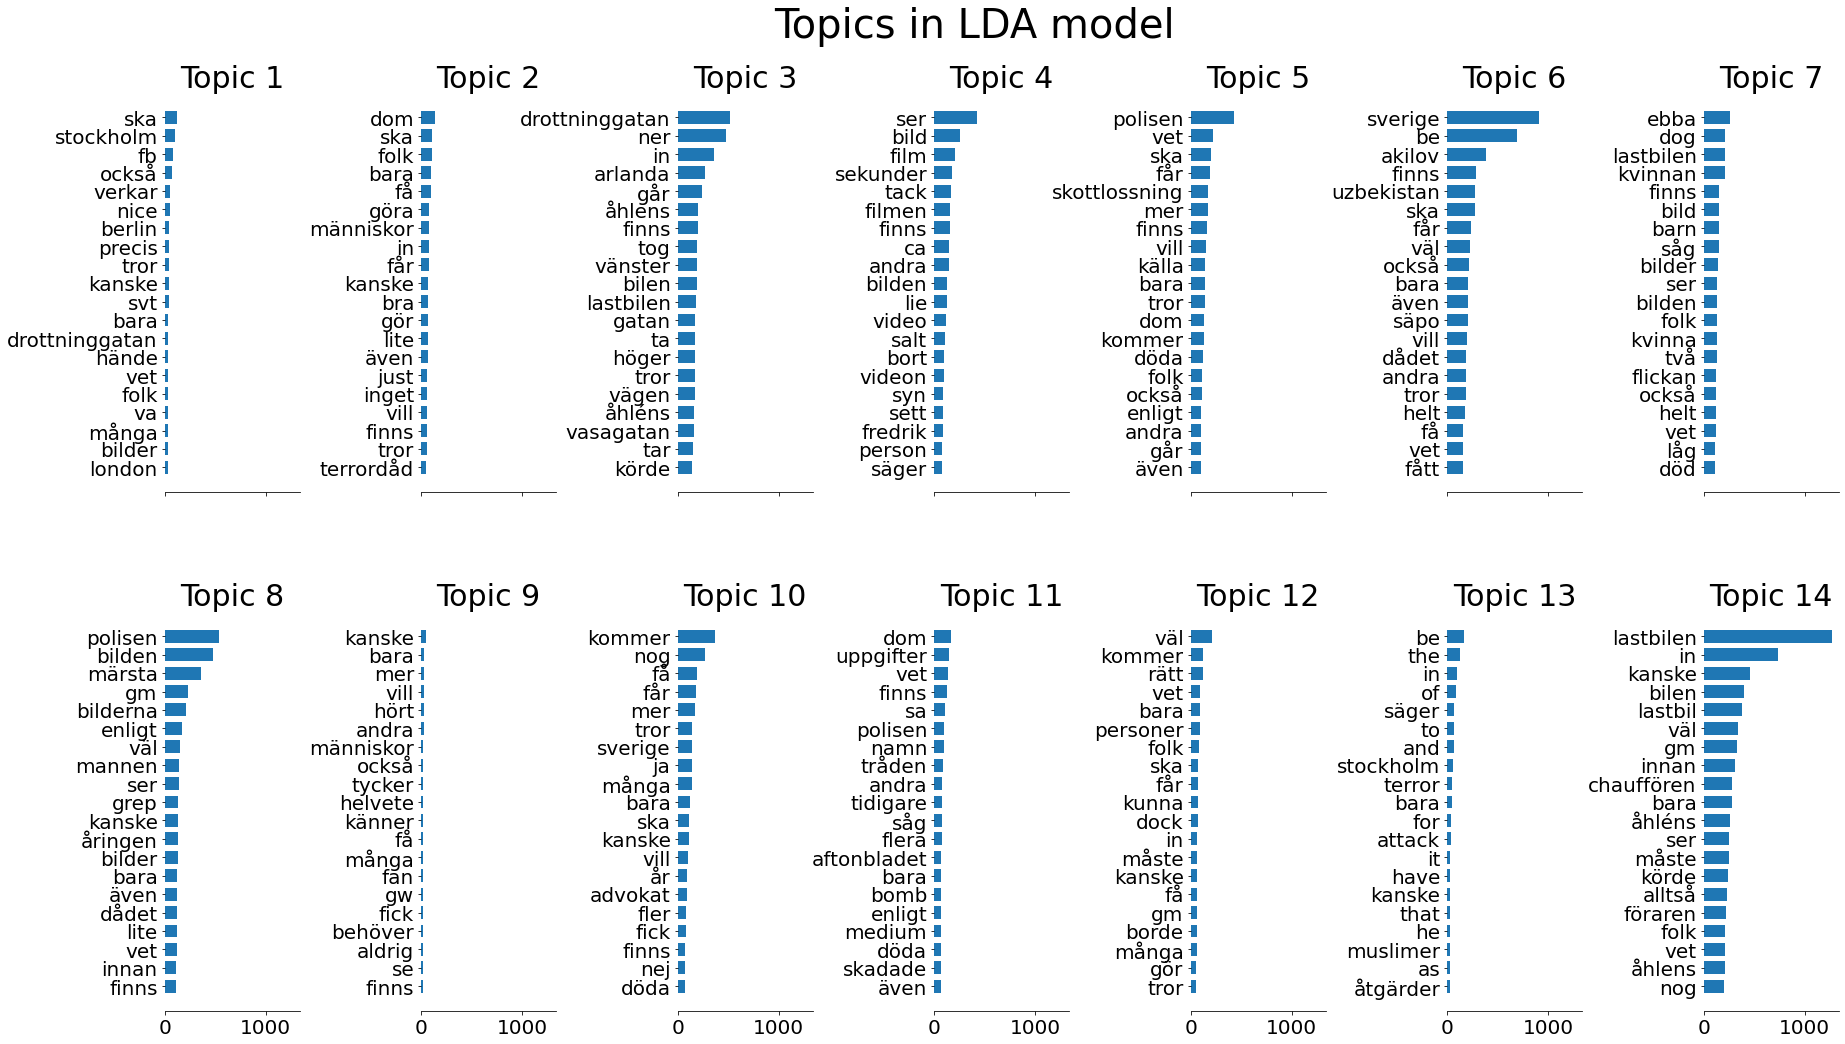

In [86]:
plot_top_words(lda14, keywords , 20, "Topics in LDA model")

In [20]:
df_14 = pd.read_csv("df-for-plot.csv")

In [72]:
df_14 = df_14.drop(['Unnamed: 0', 'index'], 1)

C:\Users\anton\AppData\Local\Temp/ipykernel_39856/4285837115.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_14 = df_14.drop(['Unnamed: 0', 'index'], 1)


In [21]:
df_14

,Unnamed: 0,post.nr,id,date,n,phaseType,Labels,comment_text,comment_lemmatized_joined,Topic1,...,Topic14,Dominant_topic,Topic_keywords_x,Topic_labels,recur,name,index,numpost,reg2,quotedummy
0,0,1,2320,4/7/2017,51,A,0,fick just samtal att en lastbil kört över mass...,fick just samtal lastbil kört massa folk drott...,0.36,...,0.00,3,"['drottninggatan', 'ner', 'in', 'arlanda', 'gå...",Navigation of truck,1,tarjaa,1,747,2013,0
1,1,2,2369,4/7/2017,116,A,0,andra trådar kopplade till terrorattentatet på...,andra trådar kopplade drottninggatan fb kommer...,0.93,...,0.00,1,"['ska', 'stockholm', 'fb', 'också', 'verkar', ...",Comparison with other attacks in Europe,11,Tinuviel,2,18455,2009,0
2,2,3,1444,4/7/2017,15,A,0,har även jag hört från en på plats nya spänna...,även hört plat nya spännande sverige tydligen ...,0.01,...,0.01,6,"['sverige', 'be', 'akilov', 'finns', 'uzbekist...",Nationality,2,Lydan,3,4015,2013,0
3,3,4,2428,4/7/2017,17,A,0,enligt nyhetsflash från aftonbladet har en las...,enligt nyhetsflash aftonbladet lastbil kört in...,0.01,...,0.37,14,"['lastbilen', 'in', 'kanske', 'bilen', 'lastbi...",Procedure of attack,79,Troian,4,28774,2003,0
4,4,5,2470,4/7/2017,1,A,0,terrorattack,terrorattack,0.54,...,0.04,1,"['ska', 'stockholm', 'fb', 'också', 'verkar', ...",Comparison with other attacks in Europe,11,Undrande87,5,3519,2013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12686,12686,13119,1064,5/13/2017,389,B,0,ja rättsstat minns jag inte om den finns defi...,ja rättsstat minns finns definierat lag mera f...,0.00,...,0.00,6,"['sverige', 'be', 'akilov', 'finns', 'uzbekist...",Nationality,130,Ikea-Kamprad,13119,9141,2011,1
12687,12687,13120,2481,5/14/2017,367,B,0,rättsstat jag har väl inte så mycket mer att...,rättsstat väl mer säga delen kommentar erkänna...,0.00,...,0.00,2,"['dom', 'ska', 'folk', 'bara', 'få', 'göra', '...",?1,266,Utredaren,13120,5853,2008,1
12688,12688,13121,1064,5/14/2017,194,B,0,undrar vad polis emma sa till akilov då hon br...,undrar polis emma sa akilov brottade ned märst...,0.00,...,0.00,6,"['sverige', 'be', 'akilov', 'finns', 'uzbekist...",Nationality,130,Ikea-Kamprad,13121,9141,2011,1
12689,12689,13122,2481,5/14/2017,146,B,0,en händelsekedja över den påstådde mgm vore br...,händelsekedja påstådde mgm vore bra etablera g...,0.00,...,0.42,14,"['lastbilen', 'in', 'kanske', 'bilen', 'lastbi...",Procedure of attack,266,Utredaren,13122,5853,2008,1


In [23]:
df_14["Topic_labels"] = df_14["Topic_labels"].apply(lambda x: x.replace("Nationality", "Sweden-Uzbekistan"))

In [25]:
df_14["Topic_labels"] = df_14["Topic_labels"].apply(lambda x: x.replace("Potential verdict for perpetrator", "Law/trial/punishment"))

In [26]:
df_14

,Unnamed: 0,post.nr,id,date,n,phaseType,Labels,comment_text,comment_lemmatized_joined,Topic1,...,Topic14,Dominant_topic,Topic_keywords_x,Topic_labels,recur,name,index,numpost,reg2,quotedummy
0,0,1,2320,4/7/2017,51,A,0,fick just samtal att en lastbil kört över mass...,fick just samtal lastbil kört massa folk drott...,0.36,...,0.00,3,"['drottninggatan', 'ner', 'in', 'arlanda', 'gå...",Navigation of truck,1,tarjaa,1,747,2013,0
1,1,2,2369,4/7/2017,116,A,0,andra trådar kopplade till terrorattentatet på...,andra trådar kopplade drottninggatan fb kommer...,0.93,...,0.00,1,"['ska', 'stockholm', 'fb', 'också', 'verkar', ...",Comparison with other attacks in Europe,11,Tinuviel,2,18455,2009,0
2,2,3,1444,4/7/2017,15,A,0,har även jag hört från en på plats nya spänna...,även hört plat nya spännande sverige tydligen ...,0.01,...,0.01,6,"['sverige', 'be', 'akilov', 'finns', 'uzbekist...",Sweden-Uzbekistan,2,Lydan,3,4015,2013,0
3,3,4,2428,4/7/2017,17,A,0,enligt nyhetsflash från aftonbladet har en las...,enligt nyhetsflash aftonbladet lastbil kört in...,0.01,...,0.37,14,"['lastbilen', 'in', 'kanske', 'bilen', 'lastbi...",Procedure of attack,79,Troian,4,28774,2003,0
4,4,5,2470,4/7/2017,1,A,0,terrorattack,terrorattack,0.54,...,0.04,1,"['ska', 'stockholm', 'fb', 'också', 'verkar', ...",Comparison with other attacks in Europe,11,Undrande87,5,3519,2013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12686,12686,13119,1064,5/13/2017,389,B,0,ja rättsstat minns jag inte om den finns defi...,ja rättsstat minns finns definierat lag mera f...,0.00,...,0.00,6,"['sverige', 'be', 'akilov', 'finns', 'uzbekist...",Sweden-Uzbekistan,130,Ikea-Kamprad,13119,9141,2011,1
12687,12687,13120,2481,5/14/2017,367,B,0,rättsstat jag har väl inte så mycket mer att...,rättsstat väl mer säga delen kommentar erkänna...,0.00,...,0.00,2,"['dom', 'ska', 'folk', 'bara', 'få', 'göra', '...",?1,266,Utredaren,13120,5853,2008,1
12688,12688,13121,1064,5/14/2017,194,B,0,undrar vad polis emma sa till akilov då hon br...,undrar polis emma sa akilov brottade ned märst...,0.00,...,0.00,6,"['sverige', 'be', 'akilov', 'finns', 'uzbekist...",Sweden-Uzbekistan,130,Ikea-Kamprad,13121,9141,2011,1
12689,12689,13122,2481,5/14/2017,146,B,0,en händelsekedja över den påstådde mgm vore br...,händelsekedja påstådde mgm vore bra etablera g...,0.00,...,0.42,14,"['lastbilen', 'in', 'kanske', 'bilen', 'lastbi...",Procedure of attack,266,Utredaren,13122,5853,2008,1


In [28]:
df_14.to_csv('df-for-plot.csv', index = True, encoding = 'utf-8-sig')

In [78]:
df_merg0

,name,index,numpost,reg2,quotedummy
0,tarjaa,1,747,2013,0
1,Tinuviel,2,18455,2009,0
2,Lydan,3,4015,2013,0
3,Troian,4,28774,2003,0
4,Undrande87,5,3519,2013,0
...,...,...,...,...,...
14711,psak,14712,3440,2010,0
14712,Siegfrid,14713,15228,2004,0
14713,vancover89,14714,118,2011,1
14714,karlinge,14715,3276,2009,0


In [75]:
df_merg0 = pd.read_csv("data-with-userinf.csv")

In [77]:
df_merg0 = df_merg0.drop(['Unnamed: 0', 'reg', 'quote'], 1)

C:\Users\anton\AppData\Local\Temp/ipykernel_39856/1953609141.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_merg0 = df_merg0.drop(['Unnamed: 0', 'reg', 'quote'], 1)


In [79]:
df_14_n = pd.merge(df_14, df_merg0, left_on = 'post.nr', right_on = 'index', how = 'inner')

In [2]:
d = pd.read_csv("df-for-plot.csv")

In [3]:
d

,Unnamed: 0.1,Unnamed: 0,post.nr,id,date,n,phaseType,Labels,comment_text,comment_lemmatized_joined,...,Topic14,Dominant_topic,Topic_keywords_x,Topic_labels,recur,name,index,numpost,reg2,quotedummy
0,0,0,1,2320,4/7/2017,51,A,0,fick just samtal att en lastbil kört över mass...,fick just samtal lastbil kört massa folk drott...,...,0.00,3,"['drottninggatan', 'ner', 'in', 'arlanda', 'gå...",Navigation of truck,1,tarjaa,1,747,2013,0
1,1,1,2,2369,4/7/2017,116,A,0,andra trådar kopplade till terrorattentatet på...,andra trådar kopplade drottninggatan fb kommer...,...,0.00,1,"['ska', 'stockholm', 'fb', 'också', 'verkar', ...",Comparison with other attacks in Europe,11,Tinuviel,2,18455,2009,0
2,2,2,3,1444,4/7/2017,15,A,0,har även jag hört från en på plats nya spänna...,även hört plat nya spännande sverige tydligen ...,...,0.01,6,"['sverige', 'be', 'akilov', 'finns', 'uzbekist...",Sweden-Uzbekistan,2,Lydan,3,4015,2013,0
3,3,3,4,2428,4/7/2017,17,A,0,enligt nyhetsflash från aftonbladet har en las...,enligt nyhetsflash aftonbladet lastbil kört in...,...,0.37,14,"['lastbilen', 'in', 'kanske', 'bilen', 'lastbi...",Procedure of attack,79,Troian,4,28774,2003,0
4,4,4,5,2470,4/7/2017,1,A,0,terrorattack,terrorattack,...,0.04,1,"['ska', 'stockholm', 'fb', 'också', 'verkar', ...",Comparison with other attacks in Europe,11,Undrande87,5,3519,2013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12686,12686,12686,13119,1064,5/13/2017,389,B,0,ja rättsstat minns jag inte om den finns defi...,ja rättsstat minns finns definierat lag mera f...,...,0.00,6,"['sverige', 'be', 'akilov', 'finns', 'uzbekist...",Sweden-Uzbekistan,130,Ikea-Kamprad,13119,9141,2011,1
12687,12687,12687,13120,2481,5/14/2017,367,B,0,rättsstat jag har väl inte så mycket mer att...,rättsstat väl mer säga delen kommentar erkänna...,...,0.00,2,"['dom', 'ska', 'folk', 'bara', 'få', 'göra', '...",?1,266,Utredaren,13120,5853,2008,1
12688,12688,12688,13121,1064,5/14/2017,194,B,0,undrar vad polis emma sa till akilov då hon br...,undrar polis emma sa akilov brottade ned märst...,...,0.00,6,"['sverige', 'be', 'akilov', 'finns', 'uzbekist...",Sweden-Uzbekistan,130,Ikea-Kamprad,13121,9141,2011,1
12689,12689,12689,13122,2481,5/14/2017,146,B,0,en händelsekedja över den påstådde mgm vore br...,händelsekedja påstådde mgm vore bra etablera g...,...,0.42,14,"['lastbilen', 'in', 'kanske', 'bilen', 'lastbi...",Procedure of attack,266,Utredaren,13122,5853,2008,1


In [80]:
df_14_n.to_csv('df-for-plot.csv', index = True, encoding = 'utf-8-sig')

In [81]:
cTox = len(df_14[df_14['Labels'] == 1])
cNonT = len(df_14[df_14['Labels'] == 0])

d_stat = {'Labels': ['Toxic', 'Non-Toxic'], 'Number_of_comments': [cTox, cNonT]}

In [82]:
d_stat = pd.DataFrame(d_stat)
d_stat

,Labels,Number_of_comments
0,Toxic,1146
1,Non-Toxic,11545


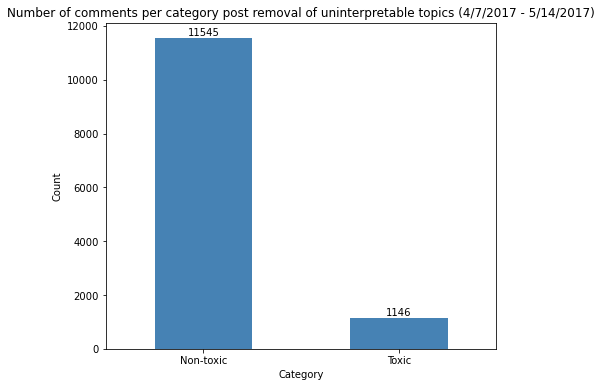

In [83]:
labs = df_14['Labels'].value_counts()
plt.figure(figsize=(7, 6))
ax = labs.plot(kind='bar', rot=0, color="steelblue")
ax.set_title("Number of comments per category post removal of uninterpretable topics (4/7/2017 - 5/14/2017)", y = 1)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_xticklabels(('Non-toxic', 'Toxic'))

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')
plt.show()

In [1971]:
#df_A.to_csv('df_A_forplot.csv', index = True, encoding = 'utf-8-sig')

In [1972]:
#df_B.to_csv('df_B_forplot.csv', index = True, encoding = 'utf-8-sig')

In [1973]:
#df_C.to_csv('df_C_forplot.csv', index = True, encoding = 'utf-8-sig')

In [1974]:
#t1 = df[df["Dominant_topic"] == 1]
#t1 = t1['Topic_keywords']
#for i in t1:
    #print(i)